***
<font size="6"><center><b> HD-CapsNet: A Hierarchical Deep Capsule Network for Image Classification </b></center></font>
***

**Changing Model Architecture**
- **(Mod-3.2)** 16-D > 8-D (Coarse > FINE) use skip connections between Secondary Capsules $Concatenate([P_{caps}, S_{coarse}])$ > input for $S_{medium}$ and $Concatenate([P_{caps}, S_{medium}])$ > input for $S_{fine}$
- Without $L_{Cons}$

# Files and Libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras import regularizers, optimizers
from tensorflow.keras import backend as K

import tensorflow_docs as tfdocs
import tensorflow_docs.plots

# Supporting Libraries:
    #Mathplot lib for ploting graphs
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
    # numpy and pandas
import numpy as np
import pandas as pd
    #system
import os
import sys
import csv
    #import other libraries
import math
import random
from datetime import datetime
from treelib import Tree
    # ML model, Dataset and evalution metrics
sys.path.append('../../') ### adding system parth for src folder
from src import datasets # load datasets
from src import MixUp # load datasets
from src import MixUp_add_loss # load datasets
from src import metrics # load hierarchcial metrics
from src import sysenv # load hierarchcial metrics
from src import models # load machine learning models

    ## Tensorflow_docs
import tensorflow_docs as tfdocs
import tensorflow_docs.plots

    # Auto reload local libraries if updated
%load_ext autoreload
%autoreload 2

# System information & GPU growth

In [2]:
systeminfo = sysenv.systeminfo()
print(systeminfo)


• Computer Name = 30BFPC1AXW95
• Working Directory = C:\Users\knoor\OneDrive - Deakin University\Deep Learning with Python\Google_Drive\Projects\Deep Learning\HD-CapsNet\Training_and_Analysis\1_EMNIST
• Python Version = 3.8.12 (default, Oct 12 2021, 03:01:40) [MSC v.1916 64 bit (AMD64)]
• TensorFlow Version = 2.8.0
• Keras Version = 2.8.0
• Current Environment = Anaconda Environment Name : py38tf


In [3]:
gpus = "0,1,2,3,4,5,6,7" ## Selecting Available gpus (Multi-GPUS)
gpus = "0" ## Selecting Available gpus (Single GPU)
gpugrowth = sysenv.gpugrowth(gpus = gpus) ## Limiting GPUS from OS environment
gpugrowth.memory_growth() #GPU memory growth

Following GPUS are selected =  0
Done: GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


# Parameters

In [4]:
train_params = {"n_epochs" : 100,
                "batch_size": 256,
                "lr": 0.001, # Initial learning rate
                "lr_decay": 0.95, # Learning rate decay
                "decay_exe": 9, #learning rate decay execution epoch after
               }
model_params = {"optimizer": tf.keras.optimizers.Adam(train_params['lr']),
                "loss_function": models.MarginLoss(),
               }

# log directory

In [5]:
directory = sysenv.log_dir('1_EMNIST/HD_CapsNet/Mod_3_2_batch')

FOLDER CREATED =  ../../logs/1_EMNIST/HD_CapsNet/Mod_3_2


# Import Dataset : FMNIST

In [6]:
dataset = datasets.E_MNIST(version = 'ALL') # importing Dataset
# dataset = datasets.E_MNIST(version = 'reduce') # importing Dataset

EMNIST dataset: Training have 112,800 samples and testing have 18,800 samples


## Learning Rate Decay Scheduler

In [7]:
def scheduler(epoch):
    learning_rate_init = train_params["lr"]
    
    if epoch > train_params["decay_exe"]:
        learning_rate_init = train_params["lr"] * (train_params["lr_decay"] ** (epoch-9))
        
    tf.summary.scalar('learning rate', data=learning_rate_init, step=epoch)
        
    return learning_rate_init

# Model Architecture

## Loss Function

In [8]:
number_of_classes_c = len(np.unique(np.argmax(dataset['y_train_coarse'], axis=1)))
number_of_classes_f = len(np.unique(np.argmax(dataset['y_train_fine'], axis=1)))

## For Dynamic LossWeights
initial_lw = models.initial_lw({"coarse": number_of_classes_c,
                                "fine": number_of_classes_f})

lossweight = {'coarse_lw' : K.variable(value = initial_lw['coarse'], dtype="float32", name="coarse_lw"),
             'fine_lw' : K.variable(value = initial_lw['fine'], dtype="float32", name="fine_lw"),
              'consistency_lw' : 0.0
             }

In [9]:
def margin_loss(y_true, y_proba):
    
    present_error_raw = tf.square(tf.maximum(0., 0.9 - y_proba), name="present_error_raw")
    absent_error_raw = tf.square(tf.maximum(0., y_proba - 0.1), name="absent_error_raw")
    L = tf.add(y_true * present_error_raw, 0.5 * (1.0 - y_true) * absent_error_raw,name="L")
    total_marginloss = tf.reduce_sum(L, axis=1, name="margin_loss")

    return total_marginloss

def CustomLoss(y_true_c, y_true_f, y_pred_c, y_pred_f, LW_C, LW_F):
   
    ML_c = margin_loss(y_true_c, y_pred_c)*LW_C
    ML_f = margin_loss(y_true_f, y_pred_f)*LW_F
    batch_loss = ML_c + ML_f
    return tf.reduce_mean(batch_loss)

## Architecture

In [10]:
def get_compiled_model():
    
    ## Calling the HD-CapsNet Model
    model = models.HD_CapsNet_Mod_3_2(input_shape     = dataset['x_train'].shape[1:], 
                                      input_shape_yc  = dataset['y_train_coarse'].shape[1:],
                                      input_shape_yf  = dataset['y_train_fine'].shape[1:], 
                                      no_coarse_class = number_of_classes_c,
                                      no_fine_class   = number_of_classes_f,
                                      PCap_n_dims     = 8, 
                                      SCap_f_dims     = 8,
                                      SCap_c_dims     = 16
                                     )
    
    ## Saving Model Architecture
    keras.utils.plot_model(model, to_file = directory+"/Architecture.png", show_shapes=True)
    
    ## Add Loss for Model
    model.add_loss(CustomLoss(y_true_c            = model.inputs[1],
                              y_true_f            = model.inputs[2], 
                              y_pred_c            = model.output[0],
                              y_pred_f            = model.output[1], 
                              LW_C                = lossweight['coarse_lw'],
                              LW_F                = lossweight['fine_lw']
                             )
                  )
    
    ## Compile Model
    model.compile(optimizer='adam',                  
                  metrics={'prediction_fine': 'accuracy',
                           'prediction_coarse': 'accuracy'}
                 )
    return model

## Compile Model

In [11]:
model = get_compiled_model()

In [12]:
model.summary()

Model: "HD-CapsNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Image (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 block1_conv1 (Conv2D)          (None, 28, 28, 64)   640         ['Input_Image[0][0]']            
                                                                                                  
 batch_normalization (BatchNorm  (None, 28, 28, 64)  256         ['block1_conv1[0][0]']           
 alization)                                                                                       
                                                                                                  
 block1_conv2 (Conv2D)          (None, 28, 28, 64)   36928       ['batch_normalization[0]

                                                                                                  
 tf.math.subtract_4 (TFOpLambda  (None, 47)          0           ['prediction_fine[0][0]']        
 )                                                                                                
                                                                                                  
 tf.math.maximum (TFOpLambda)   (None, 2)            0           ['tf.math.subtract[0][0]']       
                                                                                                  
 tf.math.subtract_2 (TFOpLambda  (None, 2)           0           ['input_yc[0][0]']               
 )                                                                                                
                                                                                                  
 tf.math.maximum_1 (TFOpLambda)  (None, 2)           0           ['tf.math.subtract_1[0][0]']     
          

## Data Augmentation

In [13]:
datagen = ImageDataGenerator(width_shift_range=0.1,
                            height_shift_range=0.1)

training_generator = MixUp_add_loss.MixupGenerator_2level(dataset['x_train'],
                                                 dataset['y_train_coarse'],
                                                 dataset['y_train_fine'],
                                                 batch_size=train_params["batch_size"],
                                                 alpha=0.2, 
                                                 datagen=datagen
                                                )()

## Callback

In [14]:
tb = keras.callbacks.TensorBoard(directory+'./tb_logs'+ datetime.now().strftime("%Y%m%d-%H%M%S"))
log = keras.callbacks.CSVLogger(directory+'/log.csv', append=True)

checkpoint = keras.callbacks.ModelCheckpoint(directory+'/epoch-best.h5',
                                             monitor='val_prediction_fine_accuracy',
                                             save_best_only=True, 
                                             save_weights_only=True, 
                                             verbose=1)

change_lw = models.LossWeightsModifier(lossweight = lossweight,
                                       initial_lw = initial_lw,
                                       directory = directory)

lr_decay = keras.callbacks.LearningRateScheduler(scheduler)

## Model Training

In [15]:
model_save_dir = str(directory+'/trained_model.h5')
try:
    model.load_weights(model_save_dir)
except:
    history = model.fit(training_generator,
                        steps_per_epoch = int(dataset['x_train'].shape[0] / train_params["batch_size"]),
                        epochs = train_params["n_epochs"],
                        validation_data = ([dataset['x_test'], dataset['y_test_coarse'], dataset['y_test_fine']],
                                           [dataset['y_test_coarse'],dataset['y_test_fine']]
                                          ),
                        callbacks = [tb,log,change_lw,lr_decay,checkpoint],
                        verbose=1
                       )
    
    model.save_weights(model_save_dir)

Epoch 1/2
1762/1762 [==============================] - ETA: 0s - loss: 0.1001 - prediction_coarse_accuracy: 0.8901 - prediction_fine_accuracy: 0.2574
  • Coarse Accuracy = 89.01% | Val_Accuracy = 92.56% | LossWeight = 0.78 
  • Fine   Accuracy = 25.74% | Val_Accuracy = 58.90% | LossWeight = 0.22 

Epoch 1: val_prediction_fine_accuracy improved from -inf to 0.58899, saving model to ../../logs/1_EMNIST/HD_CapsNet/Mod_3_2\epoch-best.h5
1762/1762 [==============================] - 67s 33ms/step - loss: 0.1001 - prediction_coarse_accuracy: 0.8901 - prediction_fine_accuracy: 0.2574 - val_loss: 0.0614 - val_prediction_coarse_accuracy: 0.9256 - val_prediction_fine_accuracy: 0.5890 - lr: 0.0010
Epoch 2/2
1762/1762 [==============================] - ETA: 0s - loss: 0.0968 - prediction_coarse_accuracy: 0.9220 - prediction_fine_accuracy: 0.8106
  • Coarse Accuracy = 92.20% | Val_Accuracy = 92.53% | LossWeight = 0.91 
  • Fine   Accuracy = 81.06% | Val_Accuracy = 86.14% | LossWeight = 0.09 

Epoch 

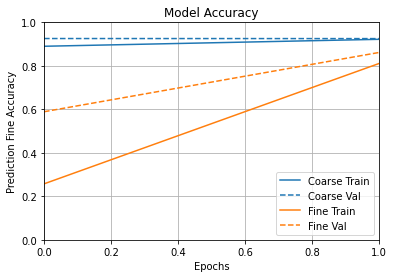

In [16]:
try:
    history_dict = history.history

    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"Coarse": history}, metric = "prediction_coarse_accuracy")
    plotter.plot({"Fine": history}, metric = "prediction_fine_accuracy")
    plt.title("Model Accuracy")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

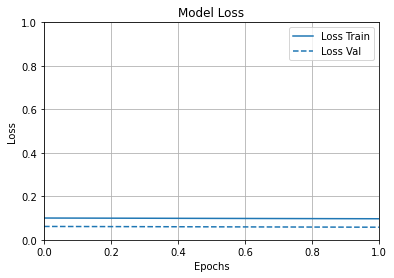

In [17]:
try:
    plotter = tfdocs.plots.HistoryPlotter()
    plotter.plot({"loss": history}, metric = "loss")
    plt.title("Model Loss")
    plt.ylim([0,1])
except:
    print('Trained model weights loaded')

## Model Analysis

In [18]:
final_model = keras.Model(model.inputs[:1], model.output)

lossfn = models.MarginLoss()
final_model.compile(optimizer='adam', 
                    loss={'prediction_fine' : lossfn,
                          'prediction_coarse' : lossfn},

                    loss_weights={'prediction_fine' : lossweight['fine_lw'],
                                  'prediction_coarse' : lossweight['coarse_lw']
                                 },

                    metrics={'prediction_fine': 'accuracy',
                             'prediction_coarse': 'accuracy'
                            }
                   )

588/588 [==============================] - 9s 13ms/step - loss: 0.0507 - prediction_coarse_loss: 0.0455 - prediction_fine_loss: 0.1012 - prediction_coarse_accuracy: 0.9253 - prediction_fine_accuracy: 0.8614
1. loss ==> 0.05068812146782875
2. prediction_coarse_loss ==> 0.04547092318534851
3. prediction_fine_loss ==> 0.10117398202419281
4. prediction_coarse_accuracy ==> 0.9253191351890564
5. prediction_fine_accuracy ==> 0.8613829612731934
588/588 [==============================] - 5s 9ms/step


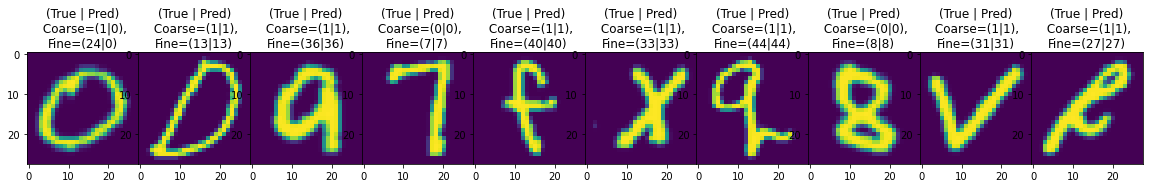

In [19]:
model_analysis = models.model_analysis(final_model, dataset)
results = model_analysis.evaluate()
predictions = model_analysis.prediction()

  • Confusion_Matrix 

  • COARSE LEVEL 
[[ 3465   535]
 [  869 13931]]

  • FINE LEVEL 
[[329   0   0 ...   0   0   0]
 [  0 275   4 ...   0   0   0]
 [  0   0 357 ...   0   0   0]
 ...
 [  1   0   0 ... 191   0   0]
 [  0   0   0 ...   0 358   2]
 [  0   1   0 ...   0   2 371]]

  • Classification Report 


  • COARSE LEVEL 


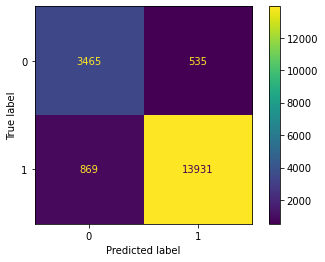

              precision    recall  f1-score   support

           0    0.79949   0.86625   0.83153      4000
           1    0.96302   0.94128   0.95203     14800

    accuracy                        0.92532     18800
   macro avg    0.88125   0.90377   0.89178     18800
weighted avg    0.92822   0.92532   0.92639     18800


  • FINE LEVEL 


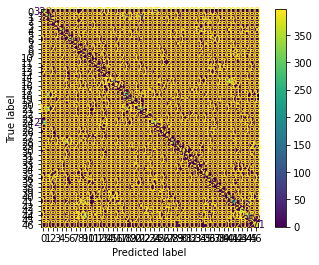

              precision    recall  f1-score   support

           0    0.58541   0.82250   0.68399       400
           1    0.48932   0.68750   0.57173       400
           2    0.87073   0.89250   0.88148       400
           3    0.98756   0.99250   0.99002       400
           4    0.98765   0.80000   0.88398       400
           5    0.77046   0.96500   0.85683       400
           6    0.97376   0.83500   0.89906       400
           7    0.95545   0.96500   0.96020       400
           8    0.85714   0.97500   0.91228       400
           9    0.64093   0.89250   0.74608       400
          10    0.94621   0.96750   0.95674       400
          11    0.93947   0.97000   0.95449       400
          12    0.97333   0.91250   0.94194       400
          13    0.81799   0.95500   0.88120       400
          14    0.91647   0.98750   0.95066       400
          15    0.75877   0.43250   0.55096       400
          16    0.93017   0.93250   0.93134       400
          17    0.96717   0

In [20]:
true_label = [dataset['y_test_coarse'],dataset['y_test_fine']]
pred_label = [predictions[0],predictions[1]]
metrics.lvl_wise_metric(true_label,pred_label)

In [21]:
h_measurements,consistency,exact_match = metrics.hmeasurements(true_label,
                                                               pred_label,
                                                               dataset['tree']
                                                              )
print('\nHierarchical Precision =',h_measurements[0],
      '\nHierarchical Recall =', h_measurements[1],
      '\nHierarchical F1-Score =',h_measurements[2],
      '\nConsistency = ', consistency,
      '\nExact Match = ', exact_match,
     )


Hierarchical Precision = 0.893421985815603 
Hierarchical Recall = 0.8991489361702127 
Hierarchical F1-Score = 0.8957127659574469 
Consistency =  0.9765957446808511 
Exact Match =  0.8504255319148936
